# TP 2 - algoritmos de ensambles 

El objetivo de este trabajo práctico es analizar las particularidades de la utilización de algoritmos de ensambles aplicados en casos casi reales. El mismo pretende fijar conceptos estudiados en la teoría: métodos de ensamble; random forests; boosting; sobreajuste; tolerancia al ruido. El material básico para la elaboración del presente trabajo se encuentra en las teóricas y prácticas presentadas hasta el momento y en las próximas clases y en las referencias bibliográficas indicadas [1,2,3]. Podrá utilizarse cualquier otra fuente siempre que esté correctamente referenciada.
El presente trabajo será grupal. El grupo deberá estar compuesto por exactamente tres integrantes. Se evaluarán los contenidos del Trabajo Práctico durante el coloquio posterior a la entrega del TP junto al material teórico y práctico enseñado en las clases de toda la materia. Todos los integrantes deben tener conocimiento del desarrollo del TP.

**Opcionales (dan puntos extra)**:

* Sumar al punto c) un modelo de perceptrón multicapa.
* Evaluar el desempeño de los modelos al utilizar el conjunto de atributos ComParE 2016.

**La fecha límite de entrega es el lunes 28 de junio a las 17:00 hs.**

**tbd** 
* Sacar a otro notebook la búsqueda de hiperparámetros de adabost, randomforest y bagging
* Sacar a otro notebook el entrenamiento del perceptron

## Cargar librerias


In [64]:
import datetime
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sweetviz as sv
import time
from matplotlib import pyplot
from numpy import mean
from numpy import std
from urllib.parse import urlparse

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [66]:
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.calibration import calibration_curve
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_curve,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import pickle
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

In [67]:
# # Observación: Descomentar en caso de que quieran versionar los modelos y la búsqueda de hiperparámetros.
# import mlflow
# import mlflow.sklearn
# from mlflow.tracking import MlflowClient

## Cargar dataset

In [68]:
df_original = pd.read_csv("01.df.procesado.csv")
# df_original = pd.read_csv("https://raw.githubusercontent.com/blukitas/AA-2021/main/TPs/02.TP/01.df.procesado.csv")
df_original.head()

,Unnamed: 0,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,start,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,./audios/ravdess/Actor_23/03-01-07-02-02-01-23...,3,1,7,2,2,1,23,0 days 00:00:00,...,0.075190,0.014015,0.022255,2.150538,1.089918,0.2825,0.126763,0.4900,0.397291,-36.658245
1,1,./audios/ravdess/Actor_23/03-02-03-02-02-01-23...,3,2,3,2,2,1,23,0 days 00:00:00,...,0.020998,0.009869,0.018871,1.492537,0.646552,0.8200,0.277248,0.5275,0.438770,-29.391884
2,2,./audios/ravdess/Actor_23/03-01-04-01-02-01-23...,3,1,4,1,2,1,23,0 days 00:00:00,...,0.047365,0.011048,0.011381,2.247191,0.569801,0.5900,0.160000,0.7600,0.296985,-43.332924
3,3,./audios/ravdess/Actor_23/03-02-04-02-02-01-23...,3,2,4,2,2,1,23,0 days 00:00:00,...,0.041743,0.012340,0.007390,1.394422,0.603622,0.9300,0.885701,0.5275,0.420260,-37.549572
4,4,./audios/ravdess/Actor_23/03-01-02-02-02-02-23...,3,1,2,2,2,2,23,0 days 00:00:00,...,0.053580,0.011590,0.005245,1.535088,0.886918,0.3875,0.206079,0.5740,0.424999,-43.261425


In [69]:
num_columns = [col for col in df_original.columns if df_original[col].dtype != "object"]
num_columns

['Unnamed: 0',
 'modality',
 'vocal_channel',
 'emotion',
 'emotional_intensity',
 'statement',
 'repetition',
 'actor',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1

In [70]:
drop_columns = [
    "file_path",
    "Unnamed: 0",
    "modality",
    "vocal_channel",
#     "emotion",
    "emotional_intensity",
    "statement",
    "repetition",
#     "actor",
]
num_columns = [x for x in num_columns if x not in drop_columns]
num_columns

['emotion',
 'actor',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3

In [71]:
df_proc = df_original[num_columns] #.head(10000)

## Split del dataset

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_proc.loc[:, df_proc.columns != "emotion"],
    df_proc["emotion"],
    stratify=df_proc["emotion"],
    random_state=66,
)

In [73]:
groups = (X_train.actor // 2) + 1

In [74]:
labels_cm = ['Neu.', 'Calm','Hap.','Sad','Angry','Fear.','Disg.','Surpr.']

## Desarrollo de modelos de ensamble

B) Elegir un modelo de ensamble visto durante las clases y entrenarlo para predecir emociones dividiendo el dataset de las siguientes maneras:
    i) 12-fold cross validation armando los folds de forma aleatoria.
    ii) Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos. Se recomienda utilizar la función de sklearn LeaveOneGroupOut

Reportar los resultados obtenidos y realizar un análisis de los mismos, teniendo en cuenta las características del dataset utilizado.

### Métricas

f1. 

Si no está desbalanceado accuracy puede ser bien. 

F1 es un poco más robusta, pensando en que tiene en cuenta recall y precision.

<BarContainer object of 8 artists>

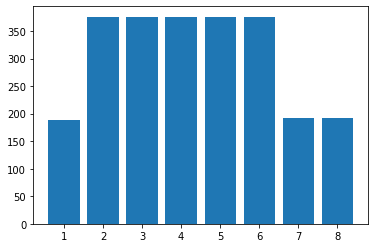

In [10]:
plt.bar(
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count(),
)

### Método elegido

Bagging con n árboles


### Árboles y búsqueda de hiperparámetros

Random search en 5000 árboles. Guardar esos 5000 en un pickle/csv para recuperarlo rápido. Quedarnos con el top 100.

#### Setup mlflow
Mlflow es una herramienta para versionado de modelos. Permite registrar paramétros, métricas y guardar los modelos entrenados asociados a una iteración.

En caso de no ser necesario comentar estas lineas.

In [25]:
# # now = datetime.datetime.now()
# mlflow.set_tracking_uri("http://mlflow_server:5000")
# tracking_uri = mlflow.get_tracking_uri()
# print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://mlflow_server:5000


In [26]:
# # No hace falta el create, el set lo crea si no existe
# experiment = mlflow.set_experiment(
#     "AA.TP2.RandomizedSearchCV.{0}".format(now.strftime("%Y-%m-%d"))
# )

INFO: 'AA.TP2.RandomizedSearchCV.2021-06-24' does not exist. Creating a new experiment


### Bagging propiamente dicho

Combinan strong learners, los cuales tienen varianza alta, para reducir su varianza. El bagging consiste en utilizar distintos subsets de los datos de entrenamiento para entrenar cada learner. Los subsets se generan tomando muestras con reemplazo. Si no se hace reemplazo se denomina **pasting**, y si en lugar de tomar subsets sobre los datos, los tomamos sobre los atributos, se denomina **random subspaces**. La combinación de bagging y random subspaces se denomina **random patches**.

https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting

Scikit Learn cuenta un tipo de objetos llamados meta-estimadores para representar a los ensambles. Este nombre se debe a que estos meta-estimadores necesitan definir estimadores base que van a ser justamente los modelos que se ajusten en cada uno de los pasos de bootstrapping. Como modelos/estimadores base podemos instanciar cualquier estimador de sklearn. Para el caso de Bagging, el meta-estimador para clasificación es:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Este objeto tiene como principal parámetro a base_estimator en el cual instanciaremos un modelo. Veamos un pequeño ejemplo:

**tbd** Acomodarlo a los árboles que usamos

In [24]:
# Version 0 del árbol

# kfold = KFold(n_splits = 12,
#                        random_state = 42, shuffle=True)
  
# # initialize the base classifier
# # TBD: Inicializar con el mejor árbol
# #      ¿Se puede inicializar con n arboles?
# # TBD: Hacer un par y compararlos? Tiene sentido?
# base_cls = DecisionTreeClassifier()
  
# # no. of base classifier
# num_trees = 1000
  
# # bagging classifier
# model = BaggingClassifier(base_estimator = base_cls,
#                           n_estimators = num_trees,
#                           random_state = 42)
  
# # max_samples en float nos dice que porcentaje del training set queremos remuestrear
# # max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos
# results = cross_val_score(model, X_train, y_train, cv = kfold)

# # fit
# model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  random_state=42)

In [54]:
start = time.time()

kfold = StratifiedKFold(n_splits=12, random_state=42, shuffle=True)
scorer_fn = make_scorer(
    f1_score, average="weighted"
)  # seteamos una metrica apropiada al problema multiclase

base_cls = DecisionTreeClassifier(class_weight="balanced")

# no. of base classifier
num_trees = 1000

# bagging classifier
model = BaggingClassifier(
    base_estimator=base_cls,
    n_estimators=num_trees,
    random_state=123,
    # shuffle=True,
    n_jobs=10,
    verbose=True,
)

results_f1 = cross_val_score(
    estimator=model, X=X_train, y=y_train, cv=kfold, n_jobs=10, scoring=scorer_fn
)
model.fit(X_train, y_train)

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   21.6s remaining:  1.4min


Tiempo: 275.89 segundos


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   22.8s finished


In [55]:
# Ref: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
# pickle.dump(model, open('03.02.Bagging_stratified_balanced.pkl', 'wb'))

In [56]:
# En caso de estar reejecutando => load model
# loaded_model = pickle.load(open('03.02.Bagging_balanced.pkl', 'rb'))
loaded_model = pickle.load(open('03.02.Bagging_stratified_balanced.pkl', 'rb'))

In [57]:
y_pred_test = loaded_model.predict(X_test)
y_pred_train = loaded_model.predict(X_train)
# evaluación
print("Accuracy training : {:.3f}".format(loaded_model.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(loaded_model.score(X_test, y_test)))

print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test, average="weighted")))
print(
    "Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1, average="weighted"))
)
print(
    "Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2, average="weighted"))
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s


Accuracy training : 1.000
Accuracy test: 0.682
Train acc: 1.0
Test acc: 0.6818923327895595
Test recall: 0.6818923327895595
Test F1: 0.6796129964914231
Test F2: 0.6805313701798359


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


En esta implementación del *BaggingClassifier* no es necesario usar estimadores base que sean *strong learners*, podemos usar cualquier tipo de estimador. Sin embargo, para que bagging performe mejor que el modelo base, si es necesaria esta condición. 

### 12-fold cross validation

In [58]:
# scores = cross_val_score(estimator=loaded_model, X=X_train, y=y_train, cv=12, n_jobs=4)

In [136]:
all_metrics = []
metric_labels = []

In [137]:
k_folds_accs = []
k_folds_precisions = []
k_folds_recalls = []
k_folds_f1 = []
k_folds_f2 = []

In [138]:

start = time.time()

k_folds_accs = cross_val_score(estimator=loaded_model, X=X_train, y=y_train, cv=12, n_jobs=4)
scorer_precision = make_scorer(precision_score, average='weighted')
k_folds_precisions = cross_val_score(
    estimator=loaded_model, X=X_train, y=y_train, cv=12, n_jobs=4, scoring=scorer_precision
)
scorer_recall = make_scorer(recall_score, average='weighted')
k_folds_recalls = cross_val_score(
    estimator=loaded_model, X=X_train, y=y_train, cv=12, n_jobs=4, scoring=scorer_recall
)
scorer_f1 = make_scorer(fbeta_score, beta=1, average='weighted')
k_folds_f1 = cross_val_score(
    estimator=loaded_model, X=X_train, y=y_train, cv=12, n_jobs=4, scoring=scorer_f1
)
# Scorer que vamos a usar durante el notebook
scorer_f2 = make_scorer(fbeta_score, beta=2, average='weighted')
k_folds_f2.append(
    cross_val_score(
        estimator=loaded_model, X=X_train, y=y_train, cv=12, n_jobs=4, scoring=scorer_f2
    )
)

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

Tiempo: 1658.97 segundos


In [139]:
all_metrics = (
    all_metrics
    + list(k_folds_accs)
    + list(k_folds_precisions)
    + list(k_folds_recalls)
    + list(k_folds_f1)
    + list(k_folds_f2[0])
)
metric_labels = (
    metric_labels
    + ["Accuracy"] * len(k_folds_accs)
    + ["Precision"] * len(k_folds_precisions)
    + ["Recall"] * len(k_folds_recalls)
    + ["F1 Score"] * len(k_folds_f1)
    + ["F2 Score"] * len(k_folds_f2[0])
)

In [140]:
len(all_metrics)

60

In [141]:
all_metrics

[0.6558441558441559,
 0.6688311688311688,
 0.6818181818181818,
 0.6339869281045751,
 0.6209150326797386,
 0.6013071895424836,
 0.6405228758169934,
 0.5947712418300654,
 0.6797385620915033,
 0.7124183006535948,
 0.6339869281045751,
 0.6862745098039216,
 0.666643709825528,
 0.6700252895291381,
 0.6819815109812464,
 0.6366526437460694,
 0.6197476162182045,
 0.6216083286052326,
 0.6444914445243486,
 0.593683457924944,
 0.6804927929204017,
 0.7187359275519347,
 0.646358637906131,
 0.6921507595681171,
 0.6558441558441559,
 0.6688311688311688,
 0.6818181818181818,
 0.6339869281045751,
 0.6209150326797386,
 0.6013071895424836,
 0.6405228758169934,
 0.5947712418300654,
 0.6797385620915033,
 0.7124183006535948,
 0.6339869281045751,
 0.6862745098039216,
 0.6575788566937191,
 0.6680898236729005,
 0.6770787653904536,
 0.6206360340380751,
 0.6182391319646222,
 0.5939544625636062,
 0.6404996681342113,
 0.5882711598034358,
 0.6757959147380868,
 0.7081093186749774,
 0.6252878460364366,
 0.6803601731472

### Leave-2-speakers out.

In [143]:
sorted(X_train.actor.unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [144]:
groups = (X_train.actor // 2) + (X_train.actor % 2)

In [146]:
# sorted(groups)
sorted(groups.unique())
groups.value_counts()

12    162
7     161
2     160
11    158
3     158
6     157
5     156
1     154
8     151
4     147
10    143
9     132
Name: actor, dtype: int64

<AxesSubplot:>

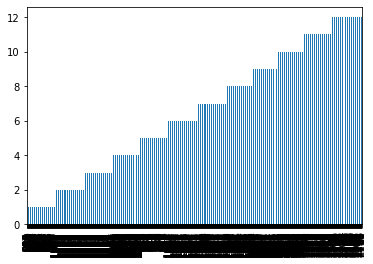

In [116]:
groups.sort_values().plot(kind='bar')

In [147]:
print(f'count: {len(X_train)}')
print(f'count: {len(y_train)}')
print(f'count: {len(groups)}')

count: 1839
count: 1839
count: 1839


In [148]:
print(f'count: {X_train.shape}')
print(f'count: {y_train.shape}')
print(f'count: {groups.shape}')

count: (1839, 89)
count: (1839,)
count: (1839,)


In [149]:
X_train

,actor,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
1565,13,23.715792,0.108936,21.457080,22.595602,26.867820,5.410740,37.066345,21.306484,13.475658,...,0.009731,0.009047,0.008891,2.564103,1.302932,0.212500,0.075952,0.426000,0.469110,-50.482838
1198,4,38.684685,0.141354,36.641376,40.478252,41.777330,5.135952,333.182900,441.709560,80.349670,...,0.091830,0.014368,0.034532,2.255639,1.015229,0.385000,0.105238,0.466000,0.451469,-30.984960
806,14,39.257828,0.156558,32.223980,41.646080,44.347458,12.123478,434.143200,611.218700,70.409325,...,0.110851,0.012034,0.013643,2.486188,1.680672,0.163333,0.103064,0.351429,0.423773,-48.948000
749,14,44.627735,0.046538,43.338448,43.977160,46.344580,3.006134,23.526870,8.470963,5.809296,...,0.130181,0.013983,0.013337,1.716738,1.301518,0.333333,0.182087,0.348571,0.437637,-44.207767
1979,18,35.964610,0.127061,33.296497,37.072433,39.491047,6.194550,170.219330,243.882420,44.904800,...,0.083365,0.012733,0.012592,1.834862,0.696056,0.493333,0.033993,0.690000,0.335857,-36.959030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,22,43.837837,0.085998,43.263270,44.117203,45.623250,2.359978,121.327140,118.337270,22.902458,...,0.065560,0.009460,0.016360,2.118644,1.070664,0.462000,0.291712,0.317143,0.438918,-29.691824
1924,5,25.633873,0.077243,24.808853,25.584507,27.265623,2.456770,100.396360,101.545060,-1.188688,...,0.000233,0.009673,0.010072,2.380952,1.208459,0.255000,0.139553,0.440000,0.463249,-47.880962
1922,5,26.447557,0.053437,25.874830,26.891346,27.354876,1.480045,41.591408,30.699524,14.224546,...,0.011561,0.001854,0.008453,1.680672,0.636943,0.213333,0.188562,1.000000,0.762758,-56.550495
1159,4,44.600105,0.034302,43.579810,43.953285,46.773098,3.193287,14.296405,5.922609,9.079408,...,0.132378,0.010170,0.005693,1.502146,0.650759,0.836667,0.595781,0.673333,0.457117,-36.843030


In [150]:
groups_accs = []
groups_precisions = []
groups_recalls = []
groups_f1 = []
groups_f2 = []

In [151]:
start = time.time()

# X = df_proc.loc[:, df_proc.columns != "emotion"]
# y = df_proc["emotion"]
logo = LeaveOneGroupOut()
logo.get_n_splits(X_train, y_train, groups)
for train_index, test_index in logo.split(X_train, y_train, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    print('x_train')
    group_X_train, group_X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    print('y_train')
    group_y_train, group_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    # print(group_X_train, group_X_test, group_y_train, group_y_test)
    
    # Train - Fit - Metrics (A array => boxplot)
    loaded_model.fit(group_X_train, group_y_train)
    group_y_pred_test = loaded_model.predict(group_X_test)
    group_y_pred_train = loaded_model.predict(group_X_train)
    # evaluación
    print("Accuracy training : {:.3f}".format(loaded_model.score(group_X_train, group_y_train)))
    print("Accuracy test: {:.3f}".format(loaded_model.score(group_X_test, group_y_test)))

    print("Train acc: {}".format(accuracy_score(group_y_train, group_y_pred_train)))
    print("Test acc: {}".format(accuracy_score(group_y_test, group_y_pred_test)))
    print("Test recall: {}".format(recall_score(group_y_test, group_y_pred_test, average='weighted')))
    print("Test F1: {}".format(fbeta_score(group_y_test, group_y_pred_test, beta=1, average='weighted')))
    print("Test F2: {}".format(fbeta_score(group_y_test, group_y_pred_test, beta=2, average='weighted')))


    groups_accs.append(accuracy_score(group_y_test, group_y_pred_test))
    groups_precisions.append(precision_score(group_y_test, group_y_pred_test, average='weighted'))
    groups_recalls.append(recall_score(group_y_test, group_y_pred_test, average='weighted'))
    groups_f1.append(fbeta_score(group_y_test, group_y_pred_test, beta=1, average='weighted'))
    groups_f2.append(fbeta_score(group_y_test, group_y_pred_test, beta=2, average='weighted')    )

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [  10   17   21   38   44   62   64  106  109  115  117  118  129  131
  152  153  161  162  163  176  184  189  205  222  233  234  243  269
  298  299  302  339  358  361  379  395  400  433  481  482  490  491
  531  533  549  555  575  610  651  656  669  699  710  727  743  764
  794  803  808  827  840  843  848  853  862  870  872  877  886  897
  903  906  915  919  927  928  952  969  976  993 1003 1018 1072 1081
 1093 1094 1114 1120 1128 1133 1135 1154 1170 1175 1176 1190 1203 1226
 1234 1246 1267 1269 1270 1323 1342 1346 1353 1356 1358 1376 1377 1385
 1387 1394 1399 1408 1410 1423 1424 1436 1453 1455 1457 1458 1461 1464
 1474 1482 1491 1497 1498 1542 1543 1547 1561 1570 1586 1595 1596 1629
 1643 1665 1667 1688 1694 1697 1731 1743 1757 1773 1787 1807 1816 1823]
x_train
y_train


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.0s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.558
Train acc: 1.0
Test acc: 0.5584415584415584
Test recall: 0.5584415584415584
Test F1: 0.5495263346805443
Test F2: 0.5496871678689274
TRAIN: [   0    2    3 ... 1835 1836 1838] TEST: [   1   19   31   40   71   89   96   97  114  122  125  141  146  149
  157  159  168  169  174  179  212  248  257  274  277  279  283  315
  336  348  368  378  380  383  384  393  403  411  417  426  429  451
  458  483  508  520  529  534  547  557  558  560  570  577  578  590
  597  624  633  638  644  653  662  683  694  700  701  703  720  740
  771  784  786  806  807  813  825  830  851  854  856  868  882  891
  893  907  918  938  946  951  963  979  994 1021 1025 1028 1030 1031
 1044 1051 1052 1061 1068 1073 1132 1173 1182 1197 1202 1209 1225 1230
 1237 1240 1245 1251 1258 1294 1308 1340 1350 1359 1362 1374 1388 1393
 1422 1432 1438 1446 1465 1477 1496 1502 1508 1546 1558 1581 1585 1589
 1592 1597 1627 1637 1648 1654 1686 1691 1700 1705 1718 1720 1726 1749
 1762 1800 1811 1

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   14.8s remaining:   59.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   15.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.531
Train acc: 1.0
Test acc: 0.53125
Test recall: 0.53125
Test F1: 0.5373327788389023
Test F2: 0.5278777719873246
TRAIN: [   0    1    2 ... 1832 1834 1837] TEST: [   8   11   20   39   70   75   80   87   95  134  136  148  164  195
  204  207  208  246  247  254  262  263  309  310  314  330  340  344
  351  360  362  365  372  385  389  390  394  401  409  423  435  439
  449  454  459  462  467  489  501  504  507  509  516  559  564  565
  580  585  618  623  658  667  685  690  702  704  712  759  774  778
  780  789  797  811  866  875  878  904  905  924  930  937  944  950
  955  957  970  978  986  990 1001 1006 1010 1011 1043 1047 1053 1067
 1076 1079 1089 1098 1099 1105 1112 1121 1127 1149 1152 1169 1174 1184
 1192 1198 1199 1231 1238 1283 1285 1298 1299 1304 1306 1321 1325 1328
 1332 1334 1344 1380 1415 1416 1447 1456 1467 1468 1471 1472 1553 1611
 1625 1626 1632 1633 1647 1653 1673 1703 1713 1721 1735 1821 1822 1825
 1833 1835 1836 1838]
x_train
y_train


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.7s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.475
Train acc: 1.0
Test acc: 0.47468354430379744
Test recall: 0.47468354430379744
Test F1: 0.45944892805479176
Test F2: 0.46451349024150956
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [   7   12   16   18   23   24   36   47   50   52   55   78   94  102
  104  107  111  124  143  155  166  171  175  181  182  200  220  228
  232  265  275  301  338  342  354  374  377  405  420  421  428  456
  488  497  518  548  569  576  593  598  603  609  619  622  627  641
  643  673  698  706  716  728  729  738  748  779  788  793  802  818
  831  833  842  857  871  899  910  913  929  934  971  980  987  995
  999 1013 1015 1022 1045 1064 1069 1077 1088 1096 1103 1126 1138 1163
 1165 1206 1215 1228 1235 1244 1248 1249 1259 1276 1277 1278 1289 1296
 1311 1347 1360 1364 1386 1400 1428 1430 1466 1483 1505 1522 1523 1531
 1541 1549 1556 1557 1559 1560 1564 1578 1583 1600 1601 1622 1630 1646
 1657 1681 1738 1746 1747 1758 1808]
x_train
y_train


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.6s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.626
Train acc: 1.0
Test acc: 0.6258503401360545
Test recall: 0.6258503401360545
Test F1: 0.6167138111519305
Test F2: 0.6160343544002327
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [  41   45   68   73   90  120  133  173  180  188  199  235  237  241
  245  259  271  280  297  303  313  325  329  334  346  347  363  364
  370  373  381  396  397  416  418  424  430  432  448  457  470  484
  495  502  503  532  535  536  541  553  556  586  594  606  607  617
  640  657  659  687  725  735  772  776  777  787  810  824  829  837
  860  864  869  881  889  890  895  908  909  911  914  923  953  954
  966  998 1008 1026 1034 1040 1059 1065 1071 1086 1090 1106 1113 1137
 1145 1158 1167 1177 1188 1195 1214 1232 1239 1281 1292 1309 1310 1315
 1316 1322 1326 1361 1363 1365 1375 1390 1404 1421 1429 1439 1444 1445
 1460 1463 1481 1489 1495 1512 1535 1538 1551 1568 1602 1607 1620 1650
 1663 1675 1678 1682 1684 1685 1709 1725 1748 1751 1763 1775 1803 1806
 1810 1829]
x_tra

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.1s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.346
Train acc: 1.0
Test acc: 0.34615384615384615
Test recall: 0.34615384615384615
Test F1: 0.3285231931573395
Test F2: 0.3361430572183748
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [  14   27   37   43   56   57   59   63   77   79   83   88   91   98
  100  110  112  113  138  147  185  194  197  242  244  258  276  287
  292  306  319  327  331  335  345  369  392  402  415  422  441  442
  460  465  473  474  476  478  485  492  513  522  524  566  582  591
  595  611  612  615  616  635  654  675  684  691  714  750  756  758
  768  773  782  798  801  822  828  847  861  865  867  892  902  912
  916  932  936  947  948  960  985  997 1002 1004 1014 1024 1027 1038
 1039 1054 1056 1057 1063 1118 1122 1136 1139 1146 1178 1185 1186 1201
 1219 1220 1224 1229 1260 1291 1301 1307 1320 1330 1351 1357 1367 1370
 1383 1427 1437 1450 1451 1478 1480 1487 1503 1511 1567 1574 1582 1588
 1624 1670 1683 1693 1698 1710 1714 1717 1719 1733 1750 1752 1778 1785
 1813 1818 1832

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.3s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.490
Train acc: 1.0
Test acc: 0.49044585987261147
Test recall: 0.49044585987261147
Test F1: 0.47635751419516964
Test F2: 0.47545176776902176
TRAIN: [   1    4    5 ... 1836 1837 1838] TEST: [   0    2    3   15   28   34   42   46   51   58   65   66   69   85
  158  183  192  206  215  226  255  290  291  296  307  318  333  349
  350  382  413  414  425  437  440  447  468  472  479  493  494  521
  525  528  537  538  539  545  551  563  571  574  584  621  628  629
  631  639  647  648  665  693  705  711  723  730  733  734  754  761
  790  792  800  804  821  836  849  876  885  896  898  939  945  972
  974  975  977  981  991 1016 1032 1048 1050 1055 1074 1075 1078 1083
 1147 1150 1151 1156 1157 1159 1160 1180 1204 1207 1213 1263 1286 1290
 1293 1297 1336 1339 1341 1343 1371 1402 1414 1417 1419 1431 1434 1448
 1452 1473 1485 1493 1501 1521 1528 1550 1563 1571 1579 1593 1614 1616
 1619 1634 1638 1644 1664 1679 1687 1689 1701 1716 1722 1724 1754 1756
 1759 1774 17

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.7s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.491
Train acc: 1.0
Test acc: 0.4906832298136646
Test recall: 0.4906832298136646
Test F1: 0.49144194254368295
Test F2: 0.4869499707185703
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [  30   33   35  150  165  170  177  178  190  201  202  223  224  225
  260  270  282  288  289  294  305  311  323  324  328  341  355  359
  367  371  387  407  408  410  419  434  443  455  463  464  487  500
  506  511  523  543  550  567  592  599  613  626  642  646  671  708
  731  739  746  762  814  815  816  820  839  874  888  900  942  959
  967 1017 1023 1029 1037 1041 1062 1085 1087 1092 1097 1101 1119 1125
 1129 1148 1171 1179 1187 1189 1196 1205 1236 1250 1256 1262 1271 1274
 1288 1295 1305 1318 1324 1329 1348 1366 1396 1407 1409 1418 1420 1469
 1470 1476 1515 1517 1519 1524 1534 1544 1552 1562 1569 1575 1576 1580
 1603 1609 1617 1618 1635 1652 1655 1662 1668 1671 1672 1696 1708 1732
 1769 1776 1779 1791 1792 1793 1799 1805 1826 1828 1831]
x_train
y_train


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.8s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.642
Train acc: 1.0
Test acc: 0.6423841059602649
Test recall: 0.6423841059602649
Test F1: 0.6423289541212307
Test F2: 0.637369212878993
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [   4    6   26   29   49   54   61   76   86   99  121  123  140  156
  160  172  210  213  227  251  286  300  304  332  337  353  386  398
  438  445  461  469  475  498  505  510  514  519  530  542  544  554
  572  583  587  588  589  600  614  625  632  663  664  668  689  695
  707  709  719  722  752  757  766  775  783  795  805  812  834  894
  921  982  984  996 1009 1046 1080 1104 1109 1141 1142 1164 1194 1252
 1265 1266 1268 1282 1287 1303 1335 1338 1349 1368 1373 1379 1397 1405
 1426 1433 1441 1454 1459 1484 1500 1504 1530 1536 1566 1577 1587 1590
 1594 1598 1605 1631 1639 1660 1669 1702 1727 1736 1741 1742 1744 1768
 1772 1788 1796 1798 1809 1812]
x_train
y_train


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.9s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.477
Train acc: 1.0
Test acc: 0.4772727272727273
Test recall: 0.4772727272727273
Test F1: 0.45715236168209805
Test F2: 0.4618881060919023
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [  22   74   81   84   92  108  119  126  128  130  135  144  145  154
  167  193  211  236  238  252  256  267  273  312  317  352  388  406
  436  452  471  486  499  512  515  540  546  568  601  602  604  605
  630  645  650  676  682  696  715  721  726  732  736  737  751  763
  781  785  791  817  835  844  850  859  863  879  880  884  887  926
  962  968  983  992 1007 1019 1020 1060 1100 1115 1117 1123 1124 1161
 1166 1168 1191 1193 1200 1210 1221 1253 1272 1279 1280 1302 1319 1327
 1331 1337 1345 1369 1382 1384 1389 1425 1449 1475 1486 1490 1492 1507
 1516 1520 1525 1529 1537 1540 1548 1554 1565 1572 1599 1604 1608 1612
 1640 1645 1659 1674 1676 1680 1699 1712 1723 1728 1729 1753 1760 1764
 1782 1789 1804]
x_train
y_train


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   17.1s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.524
Train acc: 1.0
Test acc: 0.5244755244755245
Test recall: 0.5244755244755245
Test F1: 0.5104920623531045
Test F2: 0.5135996554738521
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [   9   25   32   48   53   60   67   72   93  101  105  116  137  139
  151  186  191  198  216  218  221  229  230  250  261  268  278  295
  308  320  321  322  357  376  404  412  427  446  453  477  480  526
  527  552  573  579  608  634  637  649  652  655  661  670  672  678
  686  697  717  724  742  744  745  747  753  760  765  767  769  770
  819  826  832  883  901  917  920  922  925  931  933  935  940  941
  958  961  973  989 1012 1042 1058 1084 1091 1102 1107 1108 1110 1111
 1130 1140 1143 1144 1162 1208 1218 1222 1227 1241 1254 1352 1354 1392
 1398 1401 1412 1413 1435 1440 1442 1462 1479 1499 1509 1510 1514 1518
 1527 1532 1533 1545 1555 1613 1623 1628 1641 1642 1661 1666 1695 1704
 1706 1707 1711 1715 1730 1734 1739 1755 1761 1765 1767 1771 1783 1795
 1797 1814 1815 1

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.0s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy test: 0.582
Train acc: 1.0
Test acc: 0.5822784810126582
Test recall: 0.5822784810126582
Test F1: 0.5580625237716286
Test F2: 0.5647644187384518
TRAIN: [   0    1    2 ... 1836 1837 1838] TEST: [   5   13   82  103  127  132  142  187  196  203  209  214  217  219
  231  239  240  249  253  264  266  272  281  284  285  293  316  326
  343  356  366  375  391  399  431  444  450  466  496  517  561  562
  581  596  620  636  660  666  674  677  679  680  681  688  692  713
  718  741  749  755  796  799  809  823  838  841  845  846  852  855
  858  873  943  949  956  964  965  988 1000 1005 1033 1035 1036 1049
 1066 1070 1082 1095 1116 1131 1134 1153 1155 1172 1181 1183 1211 1212
 1216 1217 1223 1233 1242 1243 1247 1255 1257 1261 1264 1273 1275 1284
 1300 1312 1313 1314 1317 1333 1355 1372 1378 1381 1391 1395 1403 1406
 1411 1443 1488 1494 1506 1513 1526 1539 1573 1584 1591 1606 1610 1615
 1621 1636 1649 1651 1656 1658 1677 1690 1692 1737 1740 1745 1766 1770
 1780 1784 1786 1

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.4s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy training : 1.000


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.8s


Accuracy test: 0.611
Train acc: 1.0
Test acc: 0.6111111111111112
Test recall: 0.6111111111111112
Test F1: 0.6182507356136228
Test F2: 0.608527759440436
Tiempo: 244.82 segundos


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


In [152]:
all_metrics = (
    all_metrics
    + list(groups_accs)
    + list(groups_precisions)
    + list(groups_recalls)
    + list(groups_f1)
    + list(groups_f2)
)
metric_labels = (
    metric_labels
    + ["Accuracy"] * len(groups_accs)
    + ["Precision"] * len(groups_precisions)
    + ["Recall"] * len(groups_recalls)
    + ["F1 Score"] * len(groups_f1)
    + ["F2 Score"] * len(groups_f2)
)

In [153]:
len(all_metrics) # Porque 65?

120

In [154]:
all_metrics

[0.6558441558441559,
 0.6688311688311688,
 0.6818181818181818,
 0.6339869281045751,
 0.6209150326797386,
 0.6013071895424836,
 0.6405228758169934,
 0.5947712418300654,
 0.6797385620915033,
 0.7124183006535948,
 0.6339869281045751,
 0.6862745098039216,
 0.666643709825528,
 0.6700252895291381,
 0.6819815109812464,
 0.6366526437460694,
 0.6197476162182045,
 0.6216083286052326,
 0.6444914445243486,
 0.593683457924944,
 0.6804927929204017,
 0.7187359275519347,
 0.646358637906131,
 0.6921507595681171,
 0.6558441558441559,
 0.6688311688311688,
 0.6818181818181818,
 0.6339869281045751,
 0.6209150326797386,
 0.6013071895424836,
 0.6405228758169934,
 0.5947712418300654,
 0.6797385620915033,
 0.7124183006535948,
 0.6339869281045751,
 0.6862745098039216,
 0.6575788566937191,
 0.6680898236729005,
 0.6770787653904536,
 0.6206360340380751,
 0.6182391319646222,
 0.5939544625636062,
 0.6404996681342113,
 0.5882711598034358,
 0.6757959147380868,
 0.7081093186749774,
 0.6252878460364366,
 0.6803601731472

/home/User/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


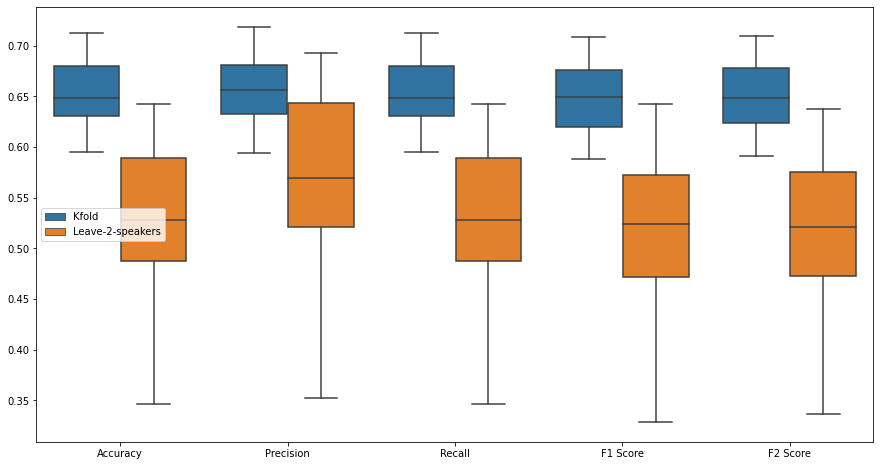

In [155]:
hue = ["Kfold"] * 60 + ["Leave-2-speakers"] * 60
fig = plt.figure(figsize=(15, 8))
sns.boxplot(metric_labels, all_metrics, hue=hue)

fig.savefig(
    "03.02.Bagging_balanced.png"
)

## Comparación de modelos

C) Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

1. Train/Test
2. Métrica
3. Busqueda hiperparámetros (Cuáles son los hiperparametros? Cual el espacio de búsqueda acotado?)
    * Random forest
    * Adaboost
4. Comparación de modelos
    * Matriz de confusión
5. Comprar ambos modelos
    * Cantados
    * Hablados

### Métrica

f1? o accuracy?

### Random Forests

Random Forest es una implementación de un algoritmo de *Bagging* que propone como estimadores base a **n_estimators** árboles de decisión. Cada árbol verá un subset distinto de los datos de entrenamiento (bagging, llamado **bootstrap** en los parámetros de sklearn). A su vez, para elegir el mejor split en cada nivel, se tienen en cuenta solo **max_features** atributos, seleccionados al azar. Estas 2 técnicas combinadas llevan a obtener árboles que sean distintos entre si y estén decorrelacionados, lo cual es bueno ya que si un árbol comete errores, probablemente otros no lo cometerán y se compensarán. Cuanto más independientes sean los árboles entre si más reduciremos la varianza.

random forest pelado

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy training : 1.000
Accuracy test: 0.715


In [75]:
random_model = pickle.load(open('03.04.Random_forest.pkl', 'rb'))

clf.best_score_
0.6508652471656616 
clf.best_params_
{'n_estimators': 3050, 'bootstrap': True}

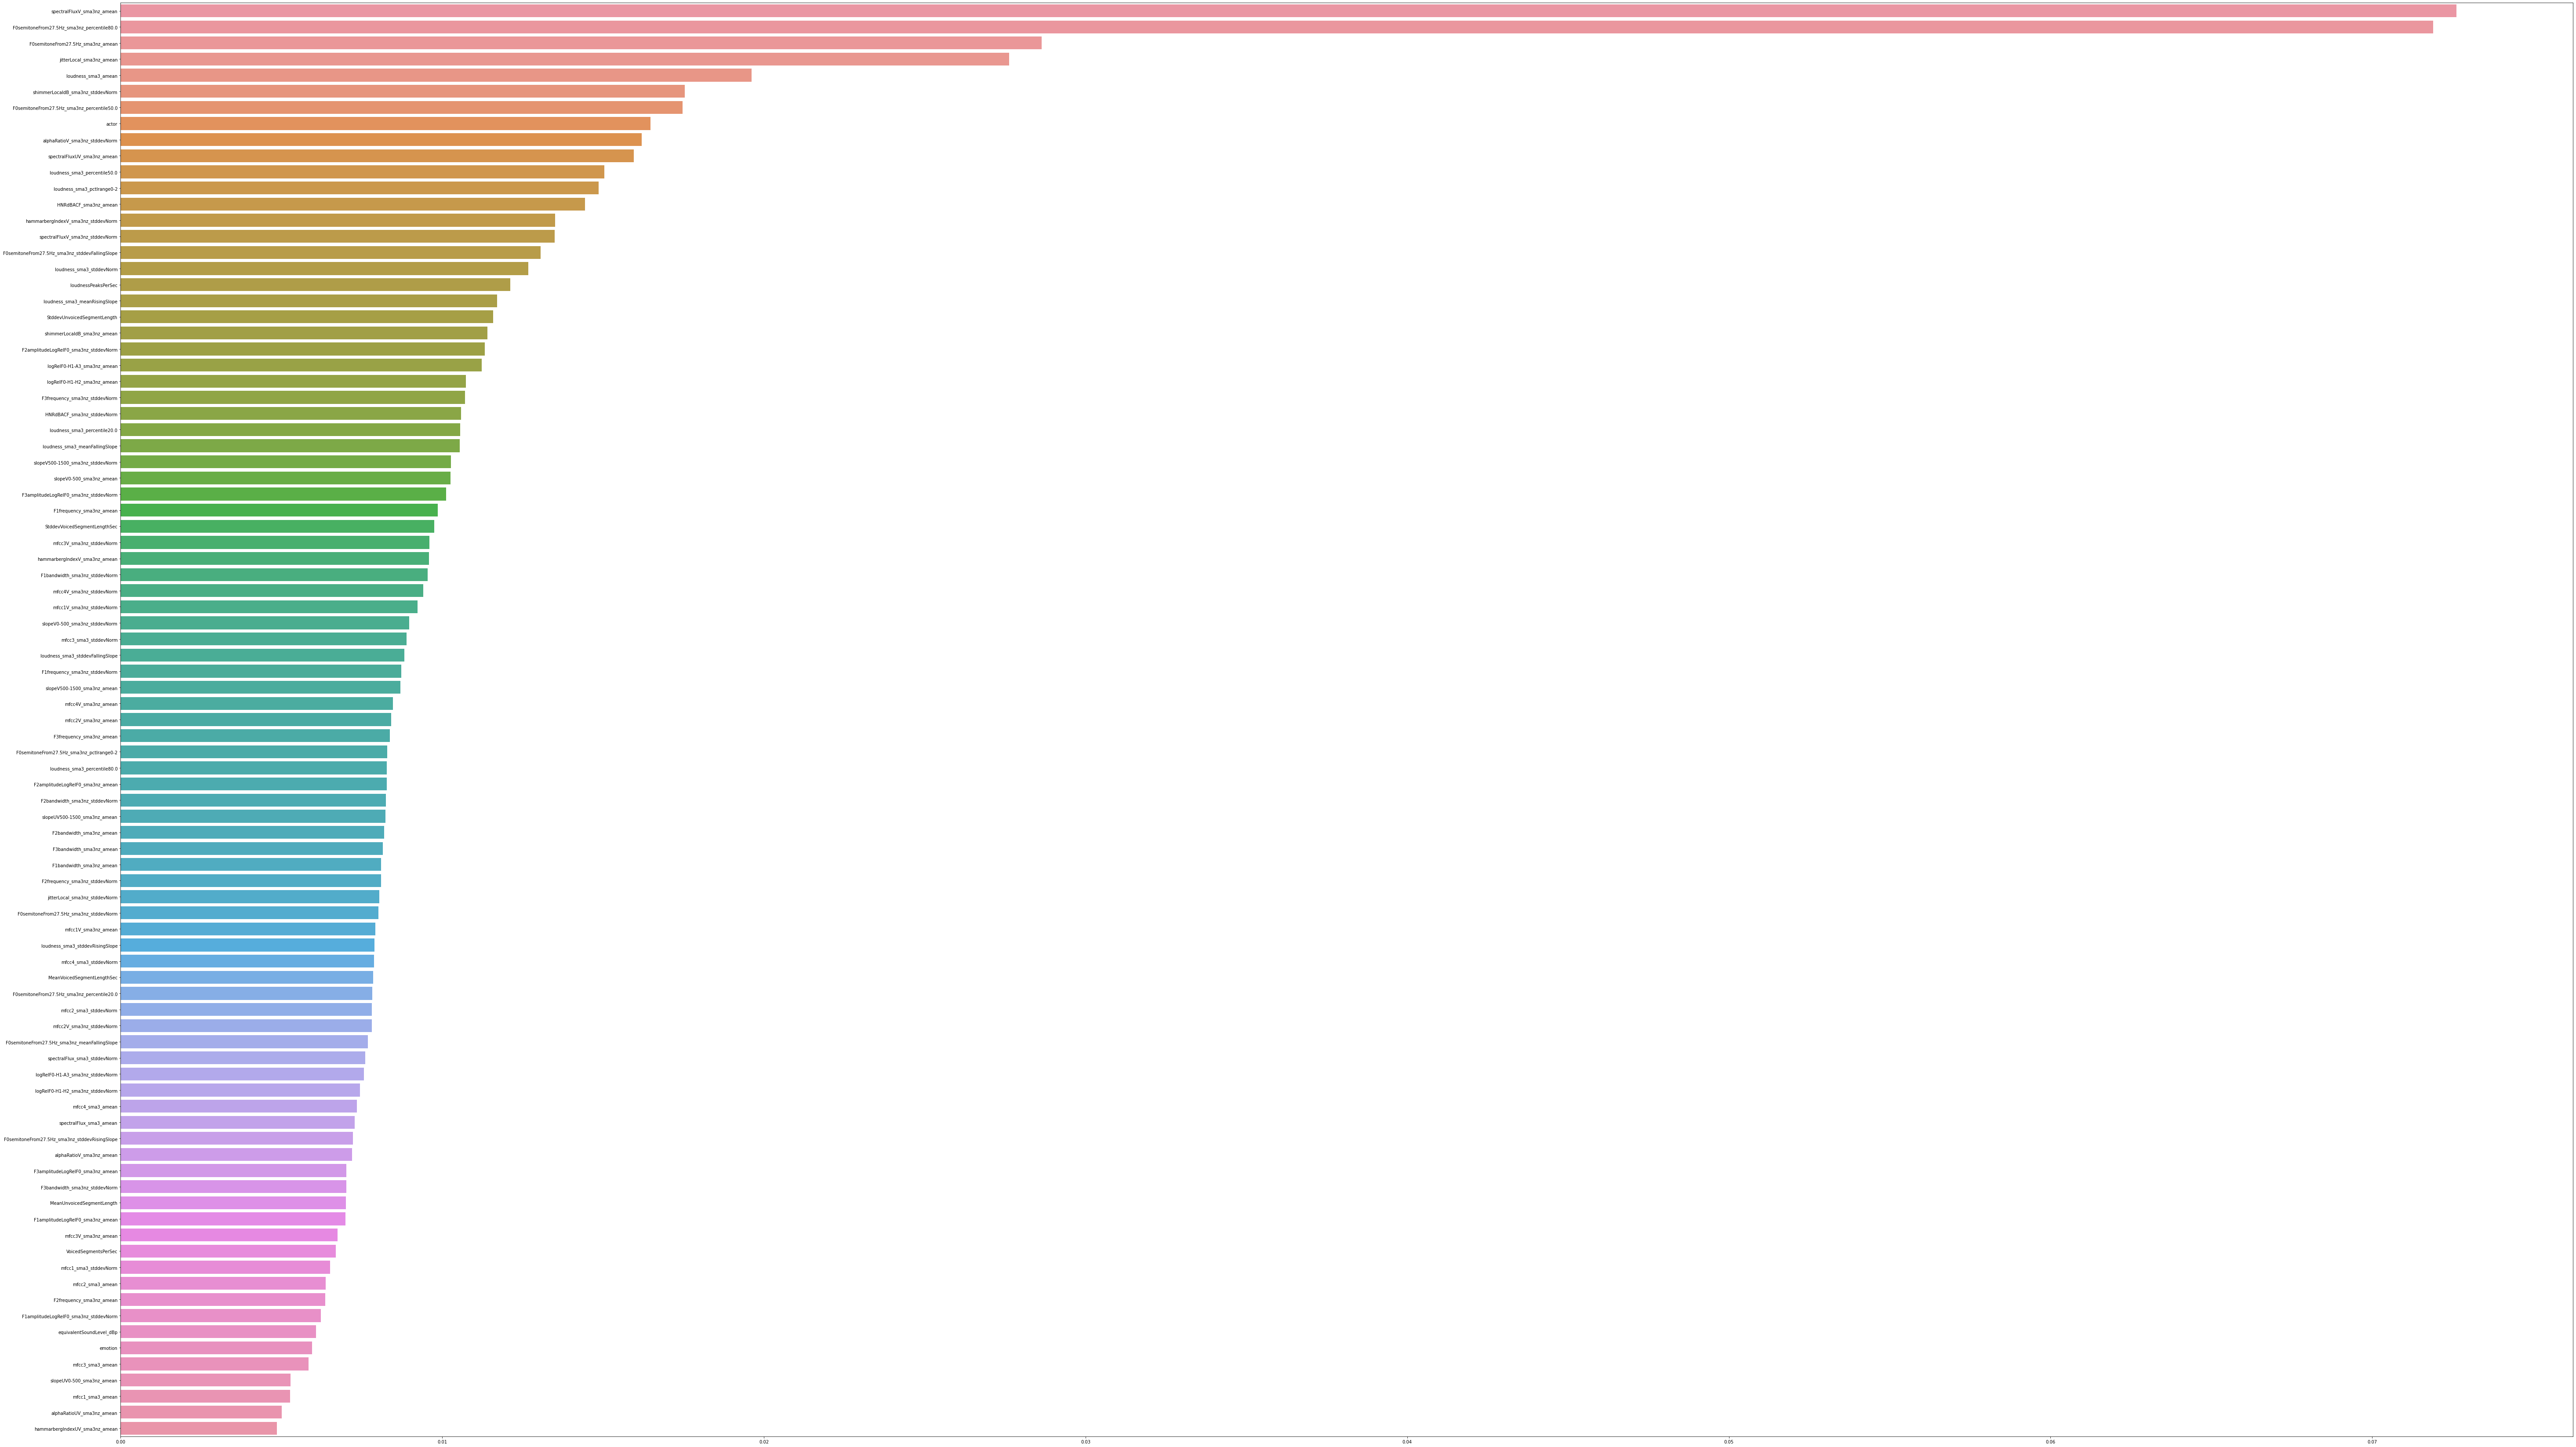

In [19]:
features = [x for i, x in enumerate(df_proc.columns) if i != 8]
feat_importances = random_model.feature_importances_

plt.figure(figsize=(100, 60))
graph_importance = sns.barplot(
    y=features,
    x=feat_importances,
    orient="h",
    order=reversed(np.array(features)[np.argsort(feat_importances)]),
)


graph_importance.figure.savefig(
    "03.04.Random_forest.feature_importante.png", bbox_inches='tight'
)

In [20]:
# df_proc.loc[:, df_proc.columns != "emotion"],
#     df_proc["emotion"],
    
importancia_predictores = pd.DataFrame(
    {"Predictor": df_proc.loc[:, df_proc.columns != "emotion"], "Importancia": random_model.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,Importancia
67,"(s, p, e, c, t, r, a, l, F, l, u, x, V, _, s, ...",0.072617
6,"(F, 0, s, e, m, i, t, o, n, e, F, r, o, m, 2, ...",0.071894
2,"(F, 0, s, e, m, i, t, o, n, e, F, r, o, m, 2, ...",0.028634
31,"(j, i, t, t, e, r, L, o, c, a, l, _, s, m, a, ...",0.027618
11,"(l, o, u, d, n, e, s, s, _, s, m, a, 3, _, a, ...",0.019615
...,...,...
27,"(m, f, c, c, 3, _, s, m, a, 3, _, a, m, e, a, n)",0.005837
79,"(s, l, o, p, e, U, V, 0, -, 5, 0, 0, _, s, m, ...",0.005278
23,"(m, f, c, c, 1, _, s, m, a, 3, _, a, m, e, a, n)",0.005272
77,"(a, l, p, h, a, R, a, t, i, o, U, V, _, s, m, ...",0.005013


In [76]:
y_pred_test = random_model.predict(X_test)
y_pred_train = random_model.predict(X_train)
# evaluación
print("Accuracy training : {:.3f}".format(random_model.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(random_model.score(X_test, y_test)))
print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test, average='weighted')))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1, average='weighted')))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2, average='weighted')))

Accuracy training : 1.000
Accuracy test: 0.690
Train acc: 1.0
Test acc: 0.6900489396411092
Test recall: 0.6900489396411092
Test F1: 0.6891785572782008
Test F2: 0.6893202868263173


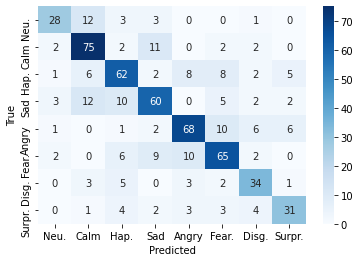

In [77]:
ax = plt.subplot()
cm = confusion_matrix(y_test, y_pred_test)
matriz_n_aria = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)

matriz_n_aria .figure.savefig(
    "03.04.Random_forest.matriz.png", bbox_inches='tight'
)

### AdaBoost
En cada iteración construye un stump nuevo y le da más peso a las muestras que fueron clasificadas mal por el anterior stump. De esta manera, en cada iteración se intenta corregir los errores que cometió el anterior clasificador. Una vez armado el ensamble, cada stump tendrá asociado un peso en sus predicciones de acuerdo a qué tan bueno fue clasificando durante el entrenamiento. A continuación les dejamos un video explicativo del funcionamiento del algoritmo:

https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

La implementación de AdaBoost de sklearn nos provee de un meta-estimador para Boosting, al cual le podemos pasar cualquier estimador (por defecto usa un arbol de profundidad 1, un stump):

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier

Paper original:
https://web.stanford.edu/~hastie/Papers/samme.pdf 


In [79]:
adaboost_model = pickle.load(open('03.05.AdaBoost.pkl', 'rb'))

clf.best_score_
0.4797936868934203 

clf.best_params_
{'n_estimators': 1640, 'learning_rate': 0.707}

In [80]:
# matriz de confusión y classification_report
y_pred_test = adaboost_model.predict(X_test)
y_pred_train = adaboost_model.predict(X_train)

# evaluación
print("Accuracy training : {:.3f}".format(adaboost_model.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(adaboost_model.score(X_test, y_test)))
print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test, average='weighted')))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1, average='weighted')))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2, average='weighted')))

Accuracy training : 1.000
Accuracy test: 0.501
Train acc: 1.0
Test acc: 0.5008156606851549
Test recall: 0.5008156606851549
Test F1: 0.5009272629011612
Test F2: 0.5006174668969426


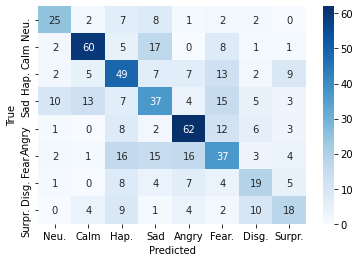

In [81]:
ax = plt.subplot()
cm = confusion_matrix(y_test, y_pred_test)
matriz_n_aria = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)


matriz_n_aria.figure.savefig(
    "03.05.Adaboost.matriz.png", bbox_inches='tight'
)

### Matriz de confusión

Mejor modelo: Random forest

Comparación cantados vs speech

#### Representatividad de cada categoría


<AxesSubplot:xlabel='emotion'>

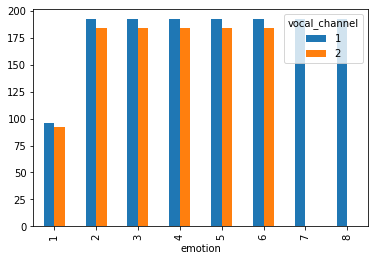

In [57]:
pd.crosstab(df_original['emotion'],df_original['vocal_channel']).plot.bar()

In [82]:
confusion_drop_columns = [
    "file_path",
    "Unnamed: 0",
    "modality",
#    "vocal_channel", # Vocal channel (01 = speech, 02 = song).
#     "emotion",
    "emotional_intensity",
    "statement",
    "repetition",
    "actor",
]

In [83]:
confusion_num_columns = [col for col in df_original.columns if df_original[col].dtype != "object" and col not in confusion_drop_columns]
confusion_num_columns

['vocal_channel',
 'emotion',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mf

In [84]:
confusion_proc = df_original[confusion_num_columns]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    confusion_proc.loc[:, confusion_proc.columns != "emotion"],
    confusion_proc["emotion"],
    stratify=df_proc["emotion"],
    random_state=66,
)

In [85]:
X_test_2.vocal_channel.value_counts()
# 1 - speech
# 2 - son

1    359
2    254
Name: vocal_channel, dtype: int64

In [86]:
y_speech_pred_test = random_model.predict(X_test_2)

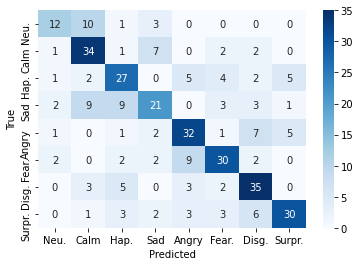

In [87]:
ax = plt.subplot()
cm = confusion_matrix(
    y_test_2[X_test_2.vocal_channel == 1],
    y_speech_pred_test[X_test_2.vocal_channel == 1],
)
heat_speech = sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,
    fmt="g",
)
plt.xlabel("Predicted")
plt.ylabel("True")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)

heat_speech.figure.savefig("04.01.Matriz.speech.png", bbox_inches="tight")

In [88]:
print(
    "Accuracy test: {:.3f}".format(
        random_model.score(
            X_test[X_test_2.vocal_channel == 1], y_test[X_test_2.vocal_channel == 1]
        )
    )
)
print(
    "Test F1: {}".format(
        fbeta_score(
            y_test[X_test_2.vocal_channel == 1],
            y_pred_test[X_test_2.vocal_channel == 1],
            beta=1,
            average="weighted",
        )
    )
)

Accuracy test: 0.618
Test F1: 0.4264912075261605


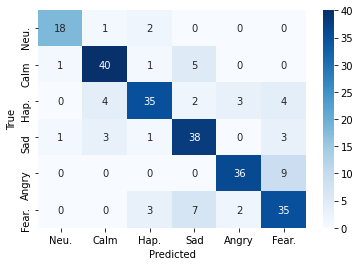

In [90]:
ax = plt.subplot()
cm = confusion_matrix(
    y_test_2[X_test_2.vocal_channel == 2],
    y_speech_pred_test[X_test_2.vocal_channel == 2],
)
heat_song = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.xaxis.set_ticklabels(labels_cm[:-2])
ax.yaxis.set_ticklabels(labels_cm[:-2])

heat_song.figure.savefig("04.01.Matriz.song.png", bbox_inches="tight")

In [63]:
print(
    "Accuracy test: {:.3f}".format(
        random_model.score(
            X_test[X_test_2.vocal_channel == 2], y_test[X_test_2.vocal_channel == 2]
        )
    )
)
print(
    "Test F1: {}".format(
        fbeta_score(
            y_test[X_test_2.vocal_channel == 2],
            y_pred_test[X_test_2.vocal_channel == 2],
            beta=1,
            average="weighted",
        )
    )
)

Accuracy test: 0.791
Test F1: 0.6109237034757022
